<a href="https://colab.research.google.com/github/YasminGarcia1210/MAESTRIA_DATOS/blob/main/Trabajo_final_VERSI%C3%93N_11_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src=http://www.acofi.edu.co/eiei2016/wp-content/uploads/2016/09/Logo-Universidad-ICESI.jpg width="200" height="200" align="center">

#**<big><big>Análisis Exploratorio de datos</big></big><br><small> Facultad de Ingeniería</small><br><small>Trabajo Final </small>**

### Yasmin Johanna García
### Javier Ricardo Muñoz
### Yesid Montaño Cuero

# TRABAJO FINAL

La exploración y análisis de datos desempeñan un papel fundamental en la comprensión y el aprovechamiento de la información contenida en conjuntos de datos empresariales. En el presente trabajo final, nos sumergimos en el apasionante mundo del análisis exploratorio de datos aplicado a una base de datos de la empresa EMTEL. EMTEL, una destacada empresa en su sector, nos brinda una valiosa oportunidad para explorar, comprender y extraer conocimientos cruciales a partir de su rica fuente de datos.

El análisis exploratorio de datos no solo es una herramienta poderosa para revelar patrones, tendencias y oportunidades ocultas, sino que también desempeña un papel fundamental en la toma de decisiones informadas y estratégicas. A lo largo de este trabajo, abordaremos de manera exhaustiva y sistemática la exploración de la base de datos de EMTEL, utilizando técnicas estadísticas, visualización de datos y métodos analíticos avanzados. Nuestro objetivo es proporcionar una visión integral de la información contenida en esta base de datos, identificar áreas de interés y generar insights que puedan guiar la toma de decisiones de manera más precisa y fundamentada

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


In [ ]:
path_retiros = "datos_retiros.csv"
path_reportes = "datos_reportes.csv"
path_peticiones = "datos_peticiones.csv"
path_servicios_activos = "datos_servicios_activos.csv"

In [ ]:
def generate_dataframe_final(path_retiros,path_reportes,path_peticiones,path_servicios_activos):
    db_retiros = pd.read_csv(path_retiros, skiprows=6, delimiter=";", encoding="latin1")
    db_reportes = pd.read_csv(path_reportes, skiprows=6,  delimiter=";", encoding="latin1")
    db_peticiones = pd.read_csv(path_peticiones, skiprows=6,  delimiter=";", encoding="latin1")
    db_servicios = pd.read_csv(path_servicios_activos, skiprows=8,  delimiter=";", encoding="latin1")

In [ ]:
path_retiros = "datos_retiros.csv"
path_reportes = "datos_reportes.csv"
path_peticiones = "datos_peticiones.csv"
path_servicios_activos = "datos_servicios_activos.csv"

def generate_dataframe_final(path_retiros,path_reportes,path_peticiones,path_servicios_activos):
    db_retiros = pd.read_csv(path_retiros, skiprows=6,delimiter=";", encoding="latin1")
    db_reportes = pd.read_csv(path_reportes, skiprows=6, delimiter=";", encoding="latin1")
    db_peticiones = pd.read_csv(path_peticiones, skiprows=6, delimiter=";", encoding="latin1")
    db_servicios = pd.read_csv(path_servicios_activos, skiprows=8, delimiter=";", encoding="latin1")

    #Liempieza de datasets

    def limpiar_datos(df: pd.DataFrame, columna: str) -> pd.DataFrame:

        df[columna] = pd.to_numeric(df[columna], errors='coerce')
        df = df.dropna(subset=[columna])
        df.reset_index(inplace=True)

        return df

    #

    db_servicios = limpiar_datos(db_servicios, 'SERVICIO')
    db_reportes = limpiar_datos(db_reportes, 'SERVICIO')
    db_retiros = limpiar_datos(db_retiros, 'SERVICIO')
    db_peticiones = limpiar_datos(db_peticiones, 'TEL ASI')

    #Eliminación de columnas no relevantes en servicios

    db_servicios = db_servicios[['SERVICIO','SUSCRIPC','CATE','SUBC','BARRIO','DESCRIPCION','SALDO','V.CUENTA','FECH INST']].copy()

    #Se añaden las columnas adicionales de  db_retiros
    def add_date_retiros(df_retiros: pd.DataFrame, df_peticiones: pd.DataFrame ):
        fechas_retiros = []
        for servicio in df_retiros['SERVICIO']:
            row = df_peticiones[df_peticiones['TEL ASI'] == servicio]
            if len(row)>0:
                valor = row['FECHA'].values[0]
            else:
                valor = "Sin fecha"

            fechas_retiros.append(valor)

        return fechas_retiros

    #Eliminación de nulos de servicios
    db_servicios=db_servicios.dropna()
    db_servicios = db_servicios.reset_index(drop=True)


    db_retiros['FECHA INS'] = add_date_retiros(db_retiros,db_peticiones)

    #Se retira retira los clientes sin fecha de petición o creación
    db_retiros = db_retiros[db_retiros['FECHA INS'] != "Sin fecha"]
    #Se filtra aquellos retiros del municipio de popayan
    db_retiros = db_retiros[db_retiros['MUPIO'] == '19001']

    #Creación de columnas necesarias para concatenación con base de retiros
    db_servicios['FECHA CIERRE'] = '31/07/2023'
    db_servicios['MOTIVO DE RETIRO'] = 'No aplica'
    db_servicios['ABANDONO'] = 0
    db_retiros['ABANDONO'] = 1
    db_retiros['DESCRIPCION'] = "Sin descripción"
    db_retiros['V.CUENTA'] = 0


    #Ajuste formato de fecha de db_servicios
    db_servicios['FECH INST'] = pd.to_datetime(db_servicios['FECH INST'], format='%d/%m/%y')
    db_servicios['FECH INST'] = db_servicios['FECH INST'].dt.strftime('%d/%m/%Y')



    db_retiros = db_retiros[['SERVICIO','SUSCRIPCION', 'CAT', 'SUB', 'BARRIO', 'DESCRIPCION', 'SALDO', 'V.CUENTA', 'FECHA INS', 'FECHA', 'MOTIVO', 'ABANDONO']].copy()

    #Se renombran conlumnas para concatenar dataframes
    db_retiros.rename(columns={'SUSCRIPCION':'SUSCRIPC', 'CAT':'CATE', 'SUB':'SUBC', 'BARRIO':'BARRIO', 'DESCRIPCION':'DESCRIPCION', 'SALDO':'SALDO', 'V.CUENTA':'V.CUENTA', 'FECHA INS':'FECH INST', 'FECHA':'FECHA CIERRE','MOTIVO':'MOTIVO DE RETIRO', 'ABANDONO':'ABANDONO'}, inplace=True)

    #Concatenar dataframes
    df = pd.concat([db_servicios,db_retiros], axis = 0)

    #Agregar dias de vigencia del servicio
    df['Dias de vigencia del servicio'] = (pd.to_datetime(df['FECHA CIERRE'], format='%d/%m/%Y') - pd.to_datetime(df['FECH INST'], format='%d/%m/%Y'))
    df['Dias de vigencia del servicio'] = df['Dias de vigencia del servicio'].astype('timedelta64[D]')
    df['Dias de vigencia del servicio'] = df['Dias de vigencia del servicio'].astype('timedelta64[D]').apply(lambda x: x / np.timedelta64(1, 'D'))
    df['Dias de vigencia del servicio'] = df['Dias de vigencia del servicio'].astype('int')

    #Agregar cantidad de reportes
    def add_cantidad_reportes(df_servicio: pd.Series, df_reportes: pd.DataFrame) -> tuple:
        cantidad_reportes = []

        for servicio in df_servicio:
            cantidad = len(df_reportes[df_reportes['SERVICIO'] == servicio])
            cantidad_reportes.append(cantidad)
        return cantidad_reportes

    df['Cantidad de reportes'] = add_cantidad_reportes(df['SERVICIO'], db_reportes)
    df.reset_index()
    return df

In [ ]:
data=generate_dataframe_final(path_retiros,path_reportes,path_peticiones,path_servicios_activos)

### 1. CONTEXTO


<img src=https://www.emtel.com.co/themes/emtel/resources/img/logo.png width="150" height="150" align="center">

EMTEL S.A. E.S.P. es una empresa de telecomunicaciones que opera en la ciudad de Popayán, Colombia, brindando una amplia gama de servicios que incluyen telefonía fija, acceso a Internet de alta velocidad, servicios de televisión por cable y otros servicios relacionados. La misión de la empresa es proporcionar conectividad confiable y servicios de comunicación avanzados tanto para hogares como para empresas y organizaciones en la región de Popayán.

La empresa se enfrenta a la competencia de otras compañías de telecomunicaciones, tanto a nivel local como nacional, lo que implica la necesidad de diferenciarse mediante precios competitivos y la oferta de servicios de alta calidad. Para lograrlo, EMTEL se compromete a garantizar una infraestructura de red robusta y de alta capacidad que pueda hacer frente a la creciente demanda de datos y comunicaciones en una ciudad en constante desarrollo. Esto, sin embargo, puede presentar desafíos en términos de inversión y logística, especialmente para asegurar una amplia cobertura geográfica, incluyendo áreas rurales y remotas.

Además, debe cumplir con las regulaciones gubernamentales y normativas en el sector de las telecomunicaciones, lo que puede tener un impacto en los servicios ofrecidos y las tarifas.

La experiencia del cliente es una prioridad para EMTEL, desde la adquisición de servicios hasta el soporte continuo. Esto es fundamental para mantener la lealtad del cliente en un mercado competitivo.

EMTEL compite tanto con empresas locales, como "Dobleclick- Conectic e ISP no formales", como con empresas nacionales como "Claro-Movistar-Tigo Une". La diferenciación a través de la calidad del servicio, la innovación y una experiencia del cliente excepcional es crucial en este contexto.

En resumen, EMTEL S.A. E.S.P. se encuentra en un mercado dinámico de telecomunicaciones en Popayán, donde enfrenta desafíos y oportunidades. La aplicación estratégica de la ciencia de datos puede ayudar a la empresa a tomar decisiones informadas y desarrollar estrategias efectivas para mejorar la retención de clientes en los próximos 12 meses. La pregunta SMART propuesta se centra en cómo utilizar el análisis de datos de comportamiento y preferencias de los clientes para identificar patrones que puedan ayudar a reducir la pérdida de clientes (churn) al 1.5% para el próximo año.

## 2. DESCRIPCIÓN DE VARIABLES



Para llevar a cabo el análisis de este trabajo, disponemos de varios informes generados desde la base de datos, los cuales se encuentran divididos en tres archivos distintos:
1.	El primer archivo contiene información sobre los servicios activos en el momento de la extracción de datos.
2.	El segundo archivo alberga los informes de las solicitudes de mantenimiento desde el año 2015 hasta la fecha actual.
3.	El tercer archivo registra los retiros de los servicios desde el año 2015.
Cada uno de estos archivos contiene una variedad de datos que son fundamentales para llevar a cabo el análisis requerido.
Para facilitar la manipulación y análisis de estos datos, hemos creado un único archivo consolidado que combina la información de los tres archivos mencionados. Este archivo consolidado se encuentra almacenado en un DataFrame llamado "df_final." En total, este DataFrame definitivo consta de 14 columnas, cada una con un propósito específico:

1.	Servicio: Esta variable identifica de manera única cada servicio en la base de datos. Cada identificador consta de 7 dígitos. Es importante mencionar que esta variable es de naturaleza cualitativa nominal.
2.	Suscripción: Representa el número de registro del usuario. Es una variable cualitativa ordinal.
3.	Categoría: Indica la categoría a la que pertenece cada servicio. Cada categoría se representa mediante una variable cualitativa nominal para los servicios de Internet, Televisión, Telefonía, Dedicados, PBX.
4.	Subcategoría: Esta variable refleja el estrato socioeconómico en el que se adquirió el servicio con valores desde el 1 al 7, donde los valores del 7 representa servicios comerciales. Fue necesario normalizar esta variable debido a diferentes tipos de codificación. Es una variable cualitativa ordinal.
5.	Barrio: Indica el lugar geográfico donde se instaló el servicio. Es una variable cualitativa nominal.
6.	Descripción: Corresponde al plan contratado para cada servicio. Es una variable cualitativa nominal.
7.	Saldo: Representa el saldo pendiente de pago y es una variable cuantitativa continua.
8.	V. Cuenta: Indica el valor a pagar por el servicio en cada período de facturación. Es una variable cuantitativa continua.
9.	Fecha Instalación: Esta variable es cualitativa ordinal y refleja la fecha en la que se instaló cada servicio.
10.	Fecha de Cierre: Esta variable e cualitativa ordinal y representa la fecha en que se realizó la solicitud de retiro de un servicio.
11.	Motivo de retiro: Esta variable es cualitativa nominal representa el motivo por el cual se realiza la solicitud del retiro.
12.	Abandono: Esta variable es cualitativa nominal, toma solo dos valores que detallan si el servicio se encuentra activo o se ha retirado.
13.	 Vigencia del servicio: Esta variable es cuantitativa discreta, toma el valor correspondiente a los días que tiene un servicio desde la fecha de instalación hasta la fecha del retiro o hasta la fecha actual si el servicio no ha sido retirado.
14.	Cantidad de reportes: Esta variable representa la acumulación de reportes desde el momento
Estas columnas proporcionan la información clave necesaria para realizar un análisis exhaustivo de los datos recopilados.

##  3. ANÁLISIS EXPLORATORIO

### 3.1 ANÁLISIS DESCRIPTIVO

#### 3.1.1 TAMAÑO DE LA DATA

In [ ]:
data. shape

(34881, 14)

La data cuenta con 34881 observaciones y 15 columnas

#### 3.1.2 Datos Nan y Null

In [ ]:
data.isna().sum()

SERVICIO                         0
SUSCRIPC                         0
CATE                             0
SUBC                             0
BARRIO                           1
DESCRIPCION                      0
SALDO                            0
V.CUENTA                         0
FECH INST                        0
FECHA CIERRE                     0
MOTIVO DE RETIRO                 0
ABANDONO                         0
Dias de vigencia del servicio    0
Cantidad de reportes             0
dtype: int64

In [ ]:
data.isnull().sum()

SERVICIO                         0
SUSCRIPC                         0
CATE                             0
SUBC                             0
BARRIO                           1
DESCRIPCION                      0
SALDO                            0
V.CUENTA                         0
FECH INST                        0
FECHA CIERRE                     0
MOTIVO DE RETIRO                 0
ABANDONO                         0
Dias de vigencia del servicio    0
Cantidad de reportes             0
dtype: int64

Podemos observar que los datos Nan y Null coinciden en las columnas, por lo que tomamos la decisión de borrar los datos Nan=Nul

Teniamos en el campo fecha de instalación NAN en 5 registros, por lo que se decidió eliminarlas


### 3.2 ANÁLISIS DE VARIABLES

In [ ]:
data.head(3)

,SERVICIO,SUSCRIPC,CATE,SUBC,BARRIO,DESCRIPCION,SALDO,V.CUENTA,FECH INST,FECHA CIERRE,MOTIVO DE RETIRO,ABANDONO,Dias de vigencia del servicio,Cantidad de reportes
0,7722586.0,98949,8,4,MODELO,TRIPLE GPON 40 MB OCT-2022,0.00,"55,010.00",31/10/2010,31/07/2023,No aplica,0,4656,0
1,7722926.0,97182,8,3,ROSALES DE LA HACIENDA,TRIPLE GPON 160 MB SEP-21,0.00,"127,390.00",28/12/2016,31/07/2023,No aplica,0,2406,0
2,7722134.0,45015,8,7,CENTRO,INTERNET GPON 15 MB JUN21,0.00,"71,390.00",22/07/2021,31/07/2023,No aplica,0,739,0


#### 3.2.1 ANÁLISIS DE VARIABLES DE CATEGORICAS

Las Variables Categóricas de nuestra Data son las columnas

SERVICIO, SUSCRIPC, CATE, SUBC, BARRIO, DESCRIPCIÓN, MOTIVO DE RETIRO

Se Harán el análisis de algunas de las Variables que son de nuestroe special interes

In [ ]:
data.dtypes

SERVICIO                         float64
SUSCRIPC                          object
CATE                              object
SUBC                              object
BARRIO                            object
DESCRIPCION                       object
SALDO                             object
V.CUENTA                          object
FECH INST                         object
FECHA CIERRE                      object
MOTIVO DE RETIRO                  object
ABANDONO                           int64
Dias de vigencia del servicio      int64
Cantidad de reportes               int64
dtype: object

#### 3.2.1.1 Tratamiento a la Variable Categorica: CATE
Esta categoria CATE será renombrada CATEGORIA


In [ ]:
# Reemplazar los valores en 'columna_a_modificar' para las filas seleccionadas
data.loc[data['CATE'] == '2', 'SUBC'] = '7'
data.loc[data['CATE'] == '5', 'SUBC'] = '7'
data.loc[data['CATE'] == '10', 'SUBC'] = '7'
data.loc[data['CATE'] == '2', 'CATE'] = '3'

In [ ]:
data = data.dropna(subset=['SUBC'])
data['SUBC'] = data['SUBC'].astype(int)

data['SUBC'] = data['SUBC'].apply(lambda x: x - 60 if x > 60 else x)
data.loc[data['SUBC'] == 8, 'SUBC'] = 7
data['SUBC'].unique()


array([ 4,  3,  7,  1,  2,  5,  6, -1])

In [ ]:
data['SUBC'].unique()

array([ 4,  3,  7,  1,  2,  5,  6, -1])

In [ ]:
#Permanece el error del -1

# Reemplazar -1 por 3 en la columna 'ESTRATO'
data['SUBC'] = data['SUBC'].replace(-1, 3)

# Guardar los cambios en un nuevo archivo
data.to_csv('nombre_del_archivo_modificado.csv', index=False)

In [ ]:
data['SUBC'].unique()

array([4, 3, 7, 1, 2, 5, 6])

#### ANÁLISIS DE LA VARIBLE CATEGORIA

La variable Categoria debe contener el tipo de servicio que tiene el cliente

** Vamos a usar un Pipeline para estandarizar la categoria CATE  usando un diccionario

  '8': 'INTERNET',
    '3': 'TELEFONIA',
    '60': 'TELEVISIÓN',
    '5': 'DEDICADO',
    '10': 'PBX'

In [ ]:
# Define the mapping dictionary
mapeo_categorias = {
    '8': 'INTERNET',
    '3': 'TELEFONIA',
    '60': 'TELEVISIÓN',
    '5': 'DEDICADO',
    '10': 'PBX',
    '12': 'TELEFONIA'

}

class MapAndFillTransformer:
    def __init__(self, mapping):
        self.mapping = mapping

    def transform(self, X):
        X['CATE'] = X['CATE'].map(self.mapping).fillna(X['CATE'])
        return X

# Create the pipeline
pipeline = Pipeline([
    ('map_and_fill', MapAndFillTransformer(mapeo_categorias))
])

# Apply the pipeline to your data
data = pipeline.transform(data)

In [ ]:
# Cambiar los nombres de las columnas usando rename
data = data.rename(columns={'CATE': 'CATEGORIA','SUBC': 'ESTRATO'})

In [ ]:
data.head(2)

,SERVICIO,SUSCRIPC,CATEGORIA,ESTRATO,BARRIO,DESCRIPCION,SALDO,V.CUENTA,FECH INST,FECHA CIERRE,MOTIVO DE RETIRO,ABANDONO,Dias de vigencia del servicio,Cantidad de reportes
0,7722586.0,98949,INTERNET,4,MODELO,TRIPLE GPON 40 MB OCT-2022,0.00,"55,010.00",31/10/2010,31/07/2023,No aplica,0,4656,0
1,7722926.0,97182,INTERNET,3,ROSALES DE LA HACIENDA,TRIPLE GPON 160 MB SEP-21,0.00,"127,390.00",28/12/2016,31/07/2023,No aplica,0,2406,0


In [ ]:
data['CATEGORIA'].unique()

array(['3', '5', '8', '60'], dtype=object)

Notemos que tenemos unos datos con etique errada por lo que usaremos un pipeline para hacer las Trasnformaciión de dichos datos

In [ ]:
def asignar_categoria_faltantes(df: pd.DataFrame):
    categorias_anteriores = df['CATEGORIA']
    servicios = df['SERVICIO'].astype(str)

    condiciones = [
        (categorias_anteriores.isin(['8', '3', '60', '5', '10', '12'])),
        (servicios.str.startswith('5')),
        (servicios.str.startswith('6')),
        (servicios.str.startswith('89'))
    ]

    opciones = [
        categorias_anteriores,
        '8',
        '60',
        '5',
    ]

    categorias_limpias = np.select(condiciones, opciones, default='3')

    return pd.Series(categorias_limpias)

# Creación de pipeline
pipeline = Pipeline([
    ('categorias_faltantes', FunctionTransformer(asignar_categoria_faltantes, validate=False))
])

# Aplicar pipeline a categoría 'CATEGORIA'
data['CATEGORIA'] = pipeline.fit_transform(data)

In [ ]:
data['CATEGORIA'].unique()

array(['3', '5', '8', '60'], dtype=object)

Notemos que solo quedan las Categorias 4,5,8 y 60

In [ ]:
data.isna().sum()

In [ ]:
data['CATEGORIA'].fillna('3', inplace=True)
data.dropna(inplace=True)
data.reset_index(inplace=True)

In [ ]:
data.head(3)

,level_0,index,SERVICIO,SUSCRIPC,CATEGORIA,ESTRATO,BARRIO,DESCRIPCION,SALDO,V.CUENTA,FECH INST,FECHA CIERRE,MOTIVO DE RETIRO,ABANDONO,Dias de vigencia del servicio,Cantidad de reportes
0,0,0,7722586.0,98949,3,4,MODELO,TRIPLE GPON 40 MB OCT-2022,0.00,"55,010.00",31/10/2010,31/07/2023,No aplica,0,4656,0
1,1,1,7722926.0,97182,3,3,ROSALES DE LA HACIENDA,TRIPLE GPON 160 MB SEP-21,0.00,"127,390.00",28/12/2016,31/07/2023,No aplica,0,2406,0
2,2,2,7722134.0,45015,3,7,CENTRO,INTERNET GPON 15 MB JUN21,0.00,"71,390.00",22/07/2021,31/07/2023,No aplica,0,739,0


In [ ]:
data.isna().sum()

index                            0
SERVICIO                         0
SUSCRIPC                         0
CATEGORIA                        0
ESTRATO                          0
BARRIO                           0
DESCRIPCION                      0
SALDO                            0
V.CUENTA                         0
FECH INST                        0
FECHA CIERRE                     0
MOTIVO DE RETIRO                 0
ABANDONO                         0
Dias de vigencia del servicio    0
Cantidad de reportes             0
dtype: int64

#### 3.2.1.2 Tratamiento a la Variable Servicio

La Variable servicio se cambiará a un string y aplicaremos un Pipeline para crear una nueva Columna con el tipo de servicio que tiene el cliente, creando una nueva columna llamado TECNOLOGÍA

In [ ]:
data['SERVICIO'] = data['SERVICIO'].astype(int)
data['SERVICIO'] = data['SERVICIO'].astype(str)

In [ ]:
# Define una función para asignar la tecnología basada en las dos primeras cifras
def asignar_tecnologia(data):
    # Diccionario de tecnologías
    tecnologias = {
        '67': 'GPON',
        '68': 'GPON',
        '78': 'GPON',
        '77': 'GPON',
        '62': 'HFC',
        '61': 'HFC',
        '63': 'HFC',
        '64': 'HFC',
        '65': 'HFC',
        '56': 'HFC',
        '51': 'INALAMBRICA',
        '58': 'COBRE',
        '89': 'FIBRA'
    }

    # Inicializar una nueva serie con "No Identificado"
    tecnologia = pd.Series("NO IDENTIFICADO", index=data.index)

    # Extraer las dos primeras cifras de la columna 'SERVICIO'
    dos_primeras_cifras = data['SERVICIO'].str[:2]

    # Asignar "HFC" a aquellos que comienzan con '4'
    tecnologia[dos_primeras_cifras.str.startswith('4')] = 'HFC'

    # Asignar tecnologías basadas en el diccionario
    tecnologia.update(dos_primeras_cifras.map(tecnologias))

    return tecnologia

# Crear el pipeline
pipeline = Pipeline([
    ('asignar_tecnologia', FunctionTransformer(asignar_tecnologia, validate=False))
])

# Aplicar el pipeline a la columna 'SERVICIO'
data['TECNOLOGIA'] = pipeline.fit_transform(data)

# Cambiar el orden de las Columnas

column_order = ['SERVICIO', 'TECNOLOGIA', 'SUSCRIPC', 'CATEGORIA', 'ESTRATO', 'BARRIO', 'DESCRIPCION', 'SALDO', 'V.CUENTA', 'FECH INST', 'FECHA CIERRE', 'MOTIVO DE RETIRO', 'ABANDONO', 'Dias de vigencia del servicio', 'Cantidad de reportes']

# Reorganizar las columnas
data= data[column_order]
data.head(3)

,SERVICIO,TECNOLOGIA,SUSCRIPC,CATEGORIA,ESTRATO,BARRIO,DESCRIPCION,SALDO,V.CUENTA,FECH INST,FECHA CIERRE,MOTIVO DE RETIRO,ABANDONO,Dias de vigencia del servicio,Cantidad de reportes
0,7722586,GPON,98949,3,4,MODELO,TRIPLE GPON 40 MB OCT-2022,0.00,"55,010.00",31/10/2010,31/07/2023,No aplica,0,4656,0
1,7722926,GPON,97182,3,3,ROSALES DE LA HACIENDA,TRIPLE GPON 160 MB SEP-21,0.00,"127,390.00",28/12/2016,31/07/2023,No aplica,0,2406,0
2,7722134,GPON,45015,3,7,CENTRO,INTERNET GPON 15 MB JUN21,0.00,"71,390.00",22/07/2021,31/07/2023,No aplica,0,739,0


In [ ]:
data['TECNOLOGIA'].unique()

array(['GPON', 'FIBRA', 'HFC', 'NO IDENTIFICADO', 'COBRE', 'INALAMBRICA'],
      dtype=object)

15. Describir la Columna TECNOLOGÍA

"La columna 'TECNOLOGÍA' es una variable categórica que proporciona información sobre el tipo de tecnología utilizada por cada cliente. Los valores posibles en esta columna incluyen:"

GPON (Gigabit Passive Optical Network) es una tecnología de acceso de fibra óptica que proporciona velocidades de banda ancha de alta velocidad.

HFC (Hybrid Fiber-Coaxial) es una tecnología de acceso que utiliza una combinación de fibra óptica y cables coaxiales para la transmisión de datos.

INALAMBRICA: La tecnología inalámbrica se refiere a conexiones de red sin cables, como Wi-Fi o redes móviles.

COBRE: El cobre se utiliza en tecnologías DSL y proporciona conexiones de banda ancha a través de líneas telefónicas de cobre.

 FIBRA: La tecnología de fibra óptica utiliza cables de fibra óptica para proporcionar velocidades de Internet extremadamente altas y es muy eficiente en la transmisión de datos.

In [ ]:
data.info()


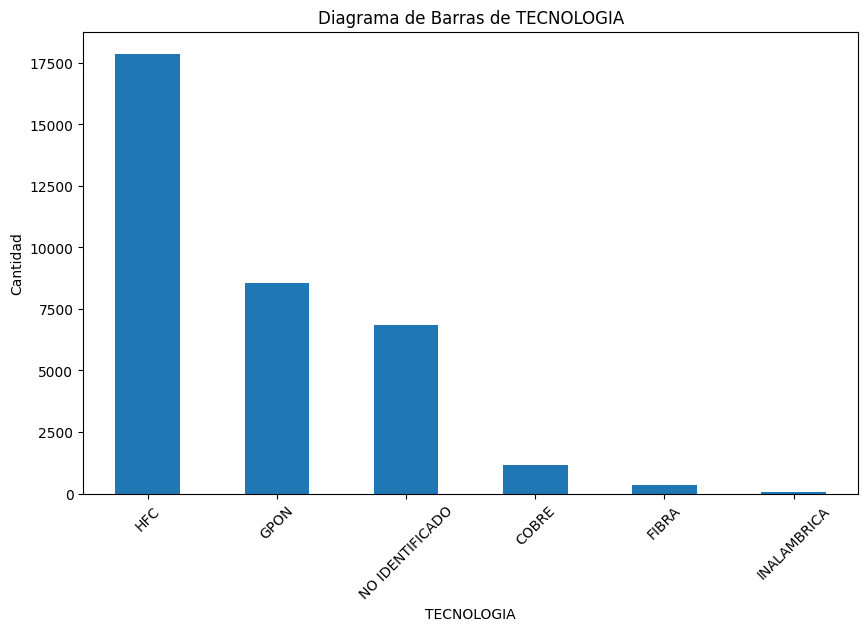

In [ ]:
# Crear el diagrama de barras
plt.figure(figsize=(10, 6))
data['TECNOLOGIA'].value_counts().plot(kind='bar')
plt.title('Diagrama de Barras de TECNOLOGIA')
plt.xlabel('TECNOLOGIA')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

### 3.2.1.3 Análisis de la Variable ABANDONO

La variable Abandono es de nuestro especial interes, puesto que el objetivo de nuestro estudio es identidfciar aquellos cleinte con una alta probabilidad de Cancelar el o los servicios adquiridos con la empresa.

En este caso tenemos que '0': ' No canceló' y '1': ' Si Cancelo el servicio'

In [ ]:
data['ABANDONO'].unique()

1

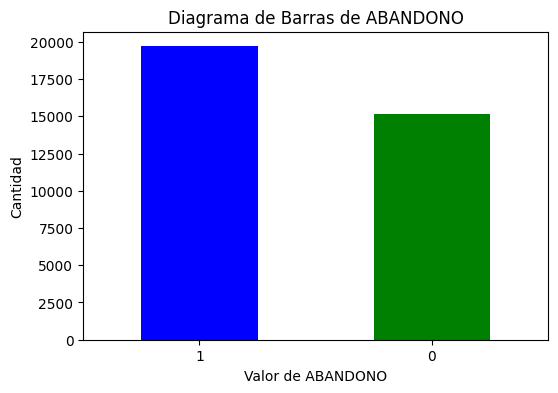

In [ ]:
# Contar la cantidad de 0s y 1s en la columna 'ABANDONO'
abandono_counts = data['ABANDONO'].value_counts()

# Crear el diagrama de barras
plt.figure(figsize=(6, 4))  # Ajusta el tamaño de la figura si es necesario
abandono_counts.plot(kind='bar', color=['blue', 'green'])

# Personalizar el gráfico (títulos, etiquetas, etc.)
plt.title('Diagrama de Barras de ABANDONO')
plt.xlabel('Valor de ABANDONO')
plt.ylabel('Cantidad')

# Mostrar el gráfico
plt.xticks(rotation=0)  # Evita la rotación de etiquetas en el eje x
plt.show()

#### 3.2.2 ANÁLISIS DE LAS VARIABLES ENTERAS

Las Variables enteras de la data son:

* Dias de Vigencia del servicio
* Cantidad de Reportes

In [ ]:
datos_negativos = data[data['Dias de vigencia del servicio'] < 0]
datos_negativos.shape

(2067, 15)

En este espacio se van a eliminar los valores de la columna 'Dias de vigencia del servicio' que sean negativos, dejando para nuestro análisis solo los que sean estricatemente positivos

In [ ]:
data=data.loc[data['Dias de vigencia del servicio']>=0]
datos_negativos = data[data['Dias de vigencia del servicio'] < 0]


In [ ]:
data_1=data[['Dias de vigencia del servicio', 'Cantidad de reportes']].describe()
data_1 = data_1.round(0)
data_1

In [ ]:
dias_vigencia=data['Dias de vigencia del servicio'].value_counts()

In [ ]:
dias_vigencia

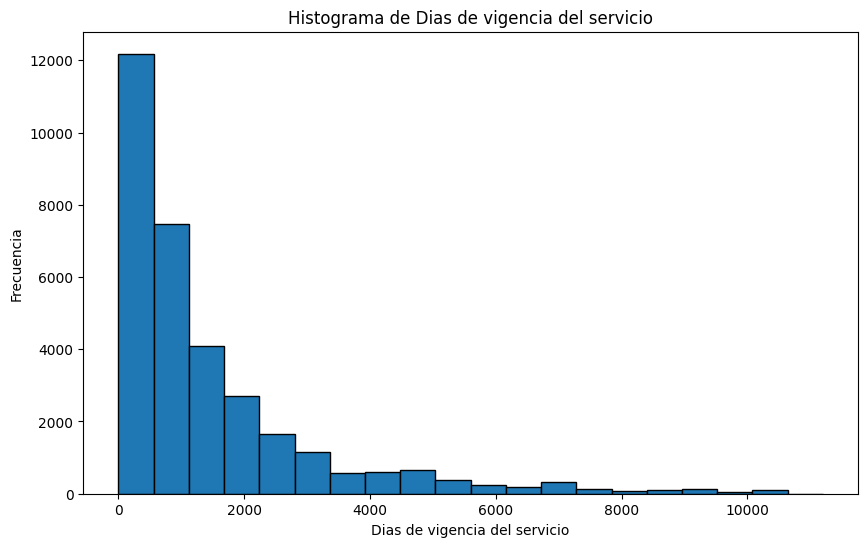

In [ ]:
# Crear el histograma
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura si es necesario
plt.hist(data['Dias de vigencia del servicio'], bins=20, edgecolor='k')

# Personalizar el gráfico (títulos, etiquetas, etc.)
plt.title('Histograma de Dias de vigencia del servicio')
plt.xlabel('Dias de vigencia del servicio')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

Variable **Cantidad de Reportes**

In [ ]:
cantidad_reportes=data['Cantidad de reportes']
cantidad_reportes.value_counts()

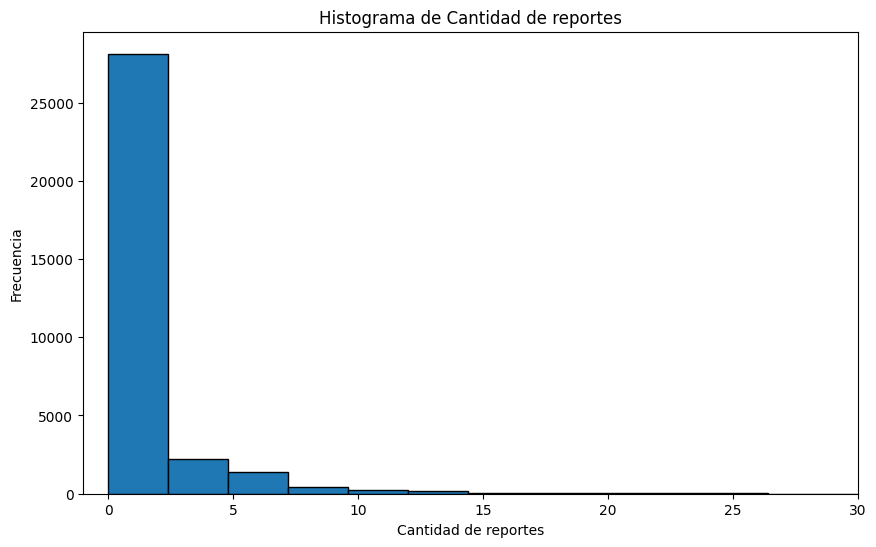

In [ ]:
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura si es necesario
plt.hist(data['Cantidad de reportes'], bins=20, edgecolor='k')

# Personalizar el gráfico (títulos, etiquetas, etc.)
plt.title('Histograma de Cantidad de reportes')
plt.xlabel('Cantidad de reportes')
plt.ylabel('Frecuencia')
plt.xlim(-1,30)
# Mostrar el gráfico
plt.show()

#### 3.2.3 ANÁLISIS DE LAS VARIABLES CONTINUAS

Las variables continuas en nuestra data son: SALDO Y V.CUENTA, en la data original aparecen con Objetos pero haremos el cambio

In [ ]:
data['SALDO'] = data['SALDO'].str.replace(',', '').astype(float)
data['V.CUENTA'] = data['V.CUENTA'].str.replace(',', '').astype(float)

In [ ]:
data_cont=data[['V.CUENTA', 'SALDO']].describe()
data_cont_rounded = data_cont.round(2)
data_cont_rounded

,V.CUENTA,SALDO
count,14534.00,32813.00
mean,50157.87,11937.70
std,167026.84,115474.89
min,0.00,-16920.00
25%,21010.00,0.00
50%,40240.00,0.00
75%,55010.00,0.00
max,16078560.00,10921110.00


In [ ]:
data['V.CUENTA'].unique()

array([ 55010., 127390.,  71390., ...,  19930.,  29660.,     nan])

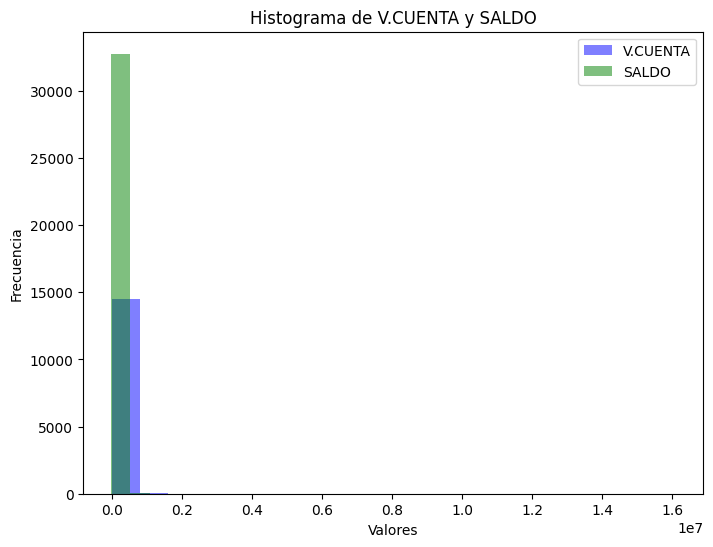

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(data['V.CUENTA'], bins=20, alpha=0.5, label='V.CUENTA', color='blue')
plt.hist(data['SALDO'], bins=20, alpha=0.5, label='SALDO', color='green')
plt.title('Histograma de V.CUENTA y SALDO')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

### 3.3 ANÁLISIS DE OUTLIERS
Vamos a analizar los datos atípico que podemos encontrar en las variables continuas

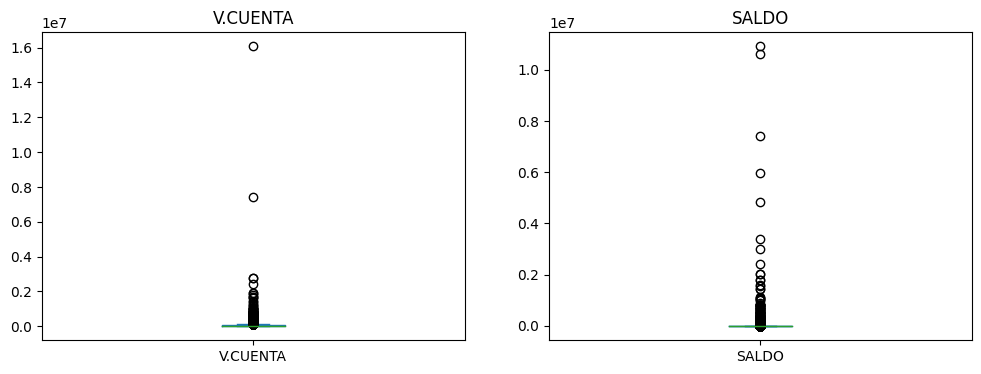

In [ ]:
import matplotlib.pyplot as plt

columnas_continuas = ['V.CUENTA', 'SALDO']

# Crea una cuadrícula de subgráficos con 1 fila y 3 columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, columna in enumerate(columnas_continuas):
    data[columna].plot.box(ax=axes[i])
    axes[i].set_title(columna)

#### 3.3.1 Análisis de los Outliers de V. Cuenta.

Podemos observar como en la Columna V.cuenta existen datos atípico demasiados alejados. esto se explica porque entre los clientes existen aquellos que son estrato 7 , los cuales se consideran corporativos. Las facturas que pagan estas empresas están muy por encima de la media.  

#### 3.3.1 Análisis de los Outliers de SALDO

Con los saldos sucede algo similar, las empresas que facturan alto en la cuenta, cuando se retrasan facturan alto en intereses aumentando asi sus saldos, los cuales están muy por encima de la mediana

#### CONCLUSIÓN DE LOS OUTLIERS

Eliminar los outliers de las empresas que facturan excesivamente en el grupo de estrato 7 resulta esencial para salvaguardar la integridad y la validez de nuestro análisis de datos. En primer lugar, las empresas con facturación extremadamente alta tienen el potencial de distorsionar de manera significativa las estadísticas y métricas de resumen que utilizamos en nuestro análisis.

Este fenómeno puede desembocar en conclusiones inexactas y decisiones erróneas basadas en datos sesgados, ya que los valores extremadamente elevados tienden a inflar la media y la desviación estándar de nuestros datos. Como consecuencia, nuestra capacidad para interpretar con precisión los resultados de nuestros modelos y tomar decisiones informadas se ve comprometida de manera negativa.

En segundo lugar, la omisión de los outliers nos permite mantener un análisis más limpio y concentrarnos en las tendencias y comportamientos típicos de las empresas que conforman el estrato 7. Esto se traduce en una mayor capacidad de nuestros modelos para identificar y generalizar patrones relevantes en los datos, lo que, a su vez, potencia nuestras predicciones y nos proporciona una comprensión más precisa de la mayoría de los casos.

En síntesis, la eliminación de los outliers provenientes de las empresas con facturación excesiva en el grupo de estrato 7 es esencial para garantizar la calidad de nuestro análisis, respaldar nuestras decisiones con datos representativos y optimizar la capacidad predictiva de nuestros modelos.

In [ ]:
data['V.CUENTA'].unique()

array([ 55010., 127390.,  71390., ...,  32080.,  19930.,  29660.])

In [ ]:
data['V.CUENTA'].fillna(40240, inplace=True)

In [ ]:
data_copy=data.copy()

In [ ]:
data_copy.shape

(32813, 15)

In [ ]:
data_copy['SALDO'].describe()

count    3.281300e+04
mean     1.193770e+04
std      1.154749e+05
min     -1.692000e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.092111e+07
Name: SALDO, dtype: float64

Vamos a tomar todos los datos que estén por debajo del tercer rango intercuartilico

In [ ]:
rango_ic = np.percentile(data_copy['V.CUENTA'], 75) - np.percentile(data_copy['V.CUENTA'], 25)
lim_superior = np.percentile(data_copy['V.CUENTA'], 75) +1.5*rango_ic
lim_superior

40240.0

In [ ]:
datos_filtrados = data_copy[data_copy['V.CUENTA'] < lim_superior]
#datos_filtrados=data_copy[data_copy['SALDO']< 50000]

In [ ]:
datos_filtrados['V.CUENTA'].describe()

count     7258.000000
mean     22059.571507
std      13324.346658
min          0.000000
25%       9050.000000
50%      21010.000000
75%      35107.500000
max      40220.000000
Name: V.CUENTA, dtype: float64

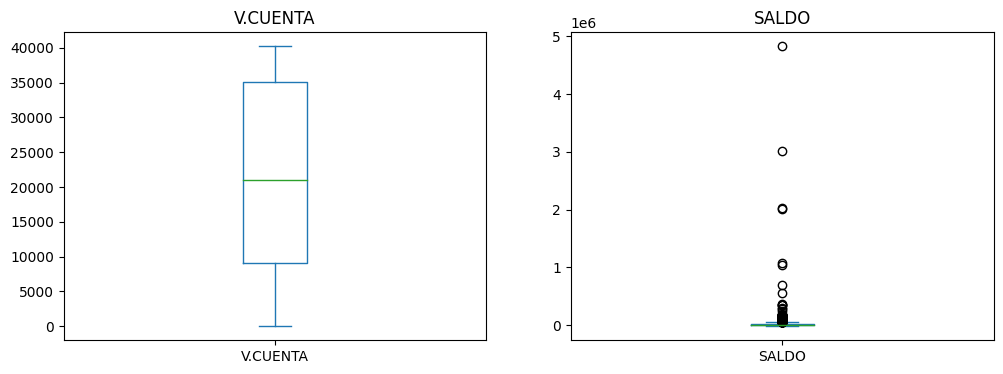

In [ ]:
import matplotlib.pyplot as plt

columnas_continuas = ['V.CUENTA', 'SALDO']

# Crea una cuadrícula de subgráficos con 1 fila y 3 columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i, columna in enumerate(columnas_continuas):
    datos_filtrados[columna].plot.box(ax=axes[i])
    axes[i].set_title(columna)

## Feuture Engineering

### Modelo de decisión

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X = data_copy[['CATEGORIA','Dias de vigencia del servicio','Cantidad de reportes']]
y = data_copy['ABANDONO']

# Separación entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
clf = DecisionTreeClassifier(max_depth=5)

# Entrenamiento
clf.fit(X_train, y_train)

# Prueba
y_pred = clf.predict(X_test)

# Precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo de árbol de decisiones: {accuracy}")

Precisión del modelo de árbol de decisiones: 0.7332012799024836


In [ ]:
df_prueba = X_test
df_prueba['test'] = y_test
df_prueba['pred'] = y_pred

df_prueba

,CATEGORIA,Dias de vigencia del servicio,Cantidad de reportes,test,pred
6595,60,642,0,0,1
22027,8,721,0,1,1
21583,8,560,5,1,1
21626,8,243,2,1,1
33198,3,371,0,1,0
...,...,...,...,...,...
26793,60,2120,1,1,1
23618,60,778,5,1,1
11273,3,1482,0,0,0
10427,3,4115,0,0,0


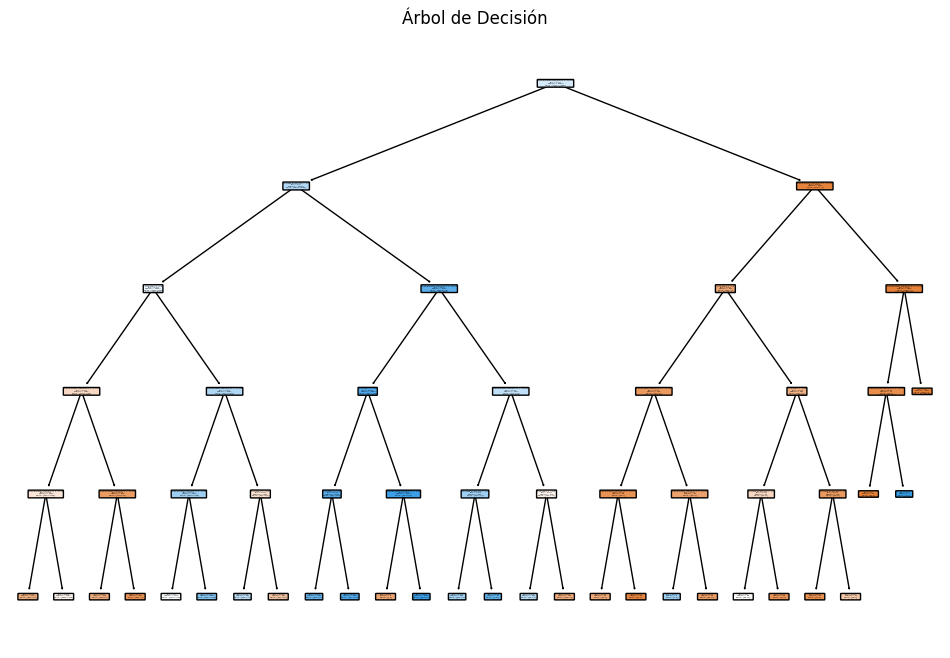

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=['No Abandono', 'Abandono'], filled=True, rounded=True)
plt.title('Árbol de Decisión')
plt.show()

## CONCLUSIÓN

El valor de precisión del modelo de árbol de decisiones de 0.70 significa que el modelo es capaz de predecir correctamente el abandono de clientes en aproximadamente el 70% de los casos en el conjunto de prueba.

En otras palabras, de todas las instancias de prueba que el modelo evaluó, aproximadamente el 70% de ellas fueron clasificadas correctamente como "abandono" o "no abandono" según las variables proporcionadas (Categoria, Dias de vigencia del servicio y Cantidad de reportes).